<a href="https://colab.research.google.com/github/tanish36/Tensorflow-Projects/blob/master/UD_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Forecasting Energy Demands With RNN
In this notebook we will learn about the 
usage of RNN for the purpose of Time Series Analysis



### Before Staring out let's first import the Library which we will need for implementing the Project 😊😊😊

In [0]:

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

#### After we have imported our library which are required we will now load our Dataset 
Our Dataset consist of Two column the first one contain the tiestamp and the next one contain the hourly energy consumption in MwgaWatts

In [0]:
url = "https://raw.githubusercontent.com/tanish36/Tensorflow-Projects/master/DOM_hourly.csv"

In [0]:
df = pd.read_csv(url, index_col='Datetime', parse_dates=['Datetime'])
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


## Checking Data
it's important to check are thier any null values or not in a dataset if they are present we need to preprocess our dataset but here it's not needed so we will not do anything

In [0]:
#checking missing data
df.isna().sum()

DOM_MW    0
dtype: int64

## Plotting the Graph
Let's check how our dataset looks on the graph as we can see from the graph their are some peaks and some dips which are repeating everyyear so after that let's normalize the data

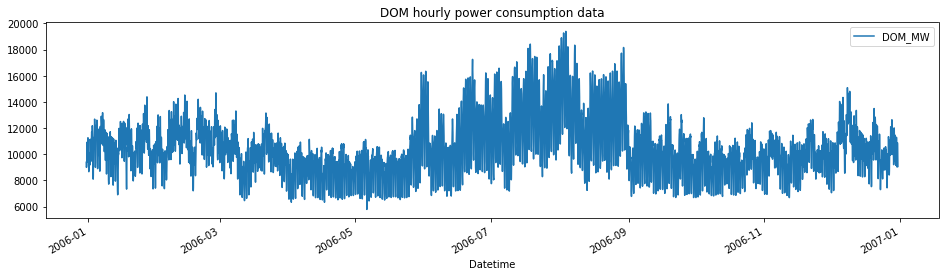

In [0]:
#@title Data Range
a= '2005-12-31'#@param {type:"date"}
b='2006-12-31' #@param {type:"date"}

a=a+" 01:00:00"
b=b+" 01:00:00"
df.loc[a:b].plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data')

plt.show()

## Normalize the Data
Before proceeding with further data analysis we must ensure that the data is normalized.<br>
For this we will be using sklearn MinMaxScaler

In [0]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(116189, 1)

Let's plot the graph after the normalizaion

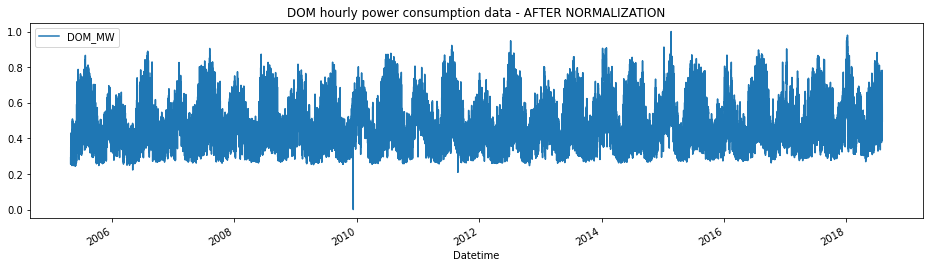

In [0]:
df_norm.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

##  Prepare data for training the RNN models



In [0]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [0]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (6169, 20, 1)
y_test.shape =  (6169,)


## Build a SIMPLE RNN model

In [0]:
from tensorflow import keras
from tensorflow.keras import layers
rnn_model = tf.keras.Sequential()

rnn_model.add(layers.SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(layers.Dropout(0.15))

rnn_model.add(layers.SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(layers.Dropout(0.15))

rnn_model.add(layers.SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(layers.Dropout(0.15))

rnn_model.add(layers.Dense(1))

rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 20, 40)            1680      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 20, 40)            3240      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_5 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

## Compiling  and training 
compile the model and then train the model on Training Dataeset

In [0]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 9s 78ms/step - loss: 0.1245
Epoch 2/10
110/110 [==============================] - 8s 76ms/step - loss: 0.0316
Epoch 3/10
110/110 [==============================] - 8s 76ms/step - loss: 0.0169
Epoch 4/10
110/110 [==============================] - 8s 75ms/step - loss: 0.0115
Epoch 5/10
110/110 [==============================] - 8s 76ms/step - loss: 0.0086
Epoch 6/10
110/110 [==============================] - 8s 76ms/step - loss: 0.0070
Epoch 7/10
110/110 [==============================] - 8s 77ms/step - loss: 0.0060
Epoch 8/10
110/110 [==============================] - 8s 76ms/step - loss: 0.0052
Epoch 9/10
110/110 [==============================] - 8s 77ms/step - loss: 0.0046
Epoch 10/10
110/110 [==============================] - 8s 77ms/step - loss: 0.0041


## Predicting 
NOw let's predict the model on the training dataset
and check it's r2 score for accuracy

In [0]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.9342229063338519


## Let's compare the actual values vs predicted values by plotting a graph
We see that the predcited values are close to the actual values meaning the RNN model is performing well in predicting the sequence.

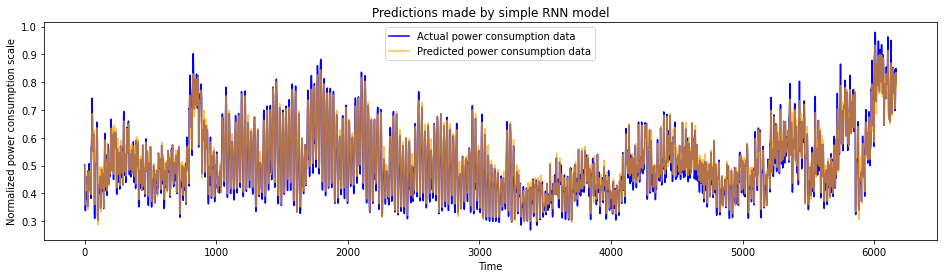

In [0]:
#@title Data Range
a=0 #@param {type:"integer"}
b=10000 #@param {type:"integer"}

def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test[a:b], color='blue',label='Actual power consumption data')
    plt.plot(predicted[a:b], alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

## Prediction on the unseen data

In [0]:
plottingvalues = list(y_train[-4000:])+list(rnn_predictions)

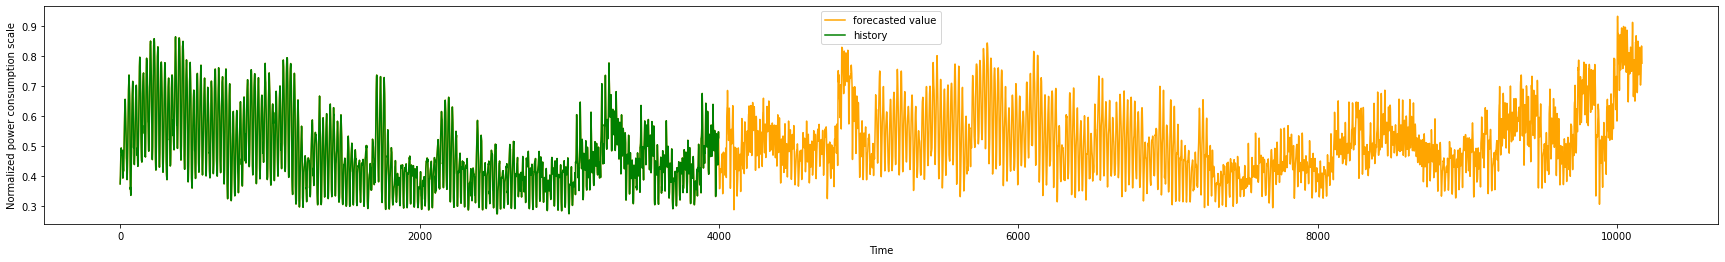

In [0]:
plt.figure(figsize=(30,4))

plt.plot(plottingvalues, color='orange',label='forecasted value')
plt.plot(y_train[-4000:], color='green',label='history')
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()

## References

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

https://machinelearningmastery.com/how-to-develop-deep-learning-models-for-univariate-time-series-forecasting/

https://www.tensorflow.org/tutorials/structured_data/time_series

https://www.tensorflow.org/api_docs/python/tf/keras/layers

In [0]:
def whole_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (len(X_train), seq_len, 1))
    
    return [X_train, y_train]

In [0]:
X_train, y_train= whole_data(df, seq_len)

In [0]:
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
117/117 [==============================] - 9s 79ms/step - loss: 0.0027
Epoch 2/10
117/117 [==============================] - 9s 79ms/step - loss: 0.0025
Epoch 3/10
117/117 [==============================] - 9s 79ms/step - loss: 0.0022
Epoch 4/10
117/117 [==============================] - 9s 80ms/step - loss: 0.0021
Epoch 5/10
117/117 [==============================] - 9s 80ms/step - loss: 0.0019
Epoch 6/10
117/117 [==============================] - 9s 80ms/step - loss: 0.0018
Epoch 7/10
117/117 [==============================] - 9s 79ms/step - loss: 0.0016
Epoch 8/10
117/117 [==============================] - 9s 79ms/step - loss: 0.0016
Epoch 9/10
117/117 [==============================] - 9s 79ms/step - loss: 0.0015
Epoch 10/10
117/117 [==============================] - 9s 80ms/step - loss: 0.0014


In [0]:
X=X_test[-1:]

In [0]:
X.shape

(1, 20, 1)

In [0]:

rnn_predictions1 = rnn_model.predict(X)

In [0]:
rnn_predictions1

array([[0.76761824]], dtype=float32)

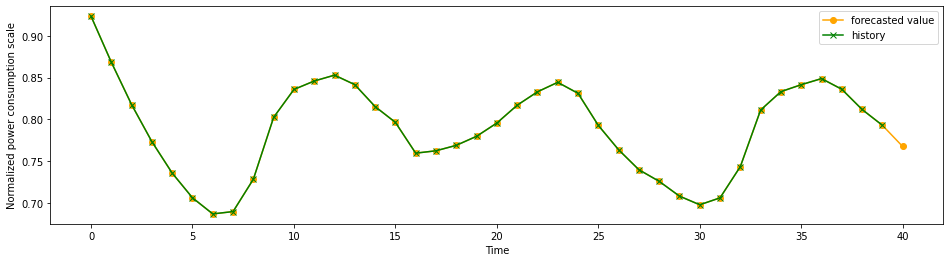

In [0]:
plottingvalues = list(y_train[-40:])+list(rnn_predictions1)
def plot_forecasteddata():
  plt.figure(figsize=(16,4))
  plt.plot(plottingvalues, color='orange',label='forecasted value',marker='o')
  plt.plot(y_train[-40:], color='green',label='history',marker='x')
  plt.xlabel('Time')
  plt.ylabel('Normalized power consumption scale')
  plt.legend()
  plt.show()
plot_forecasteddata() 

## Alternate Path

In [0]:
X=X_test[-1:]

In [0]:
X

array([[[0.77978233],
        [0.79566624],
        [0.81694284],
        [0.83297382],
        [0.84434749],
        [0.83120894],
        [0.79287185],
        [0.76370232],
        [0.73982743],
        [0.72595352],
        [0.70825571],
        [0.69791156],
        [0.70619669],
        [0.74360231],
        [0.81125601],
        [0.83321894],
        [0.84150407],
        [0.84880871],
        [0.83606236],
        [0.81189332]]])

In [0]:
X.shape

(1, 20, 1)

In [0]:
rnn_predictions1 = rnn_model.predict(X)

In [0]:
rnn_predictions1

array([[0.7772594]], dtype=float32)

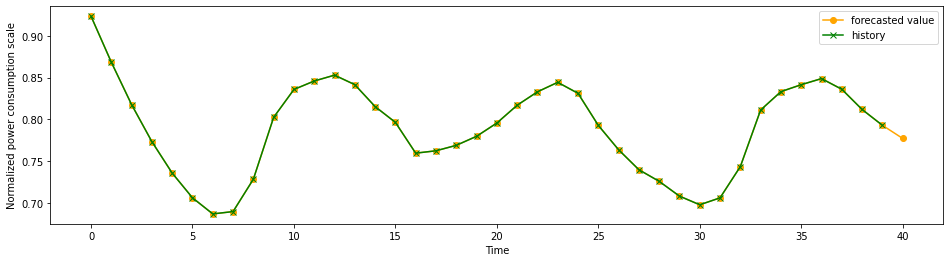

In [0]:
plottingvalues = list(y_test[-40:])+list(rnn_predictions1)
def plot_forecasteddata():
  plt.figure(figsize=(16,4))
  plt.plot(plottingvalues, color='orange',label='forecasted value',marker='o')
  plt.plot(y_test[-40:], color='green',label='history',marker='x')
  plt.xlabel('Time')
  plt.ylabel('Normalized power consumption scale')
  plt.legend()
  plt.show()
plot_forecasteddata() 